In [1]:
import os
import numpy as np
import torch
from scipy.ndimage import zoom
from math import pi
from torch import nn
import pandas as pd
from torch.nn import MSELoss
from torch.optim import Adam

print("Using torch", torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

interesting_region=np.load("./interesting_region.npy")
fo=np.load("./random_parameters.npz")
wl_array=fo["arr_0"]
slit_array=fo["arr_1"]
alpha_array=fo["arr_2"]
beta_array=fo["arr_3"]

dataset_size=5000
split_size=[4500,250,250]
seed=715
wl_resolution = 60

ori_size=np.load("./data0.npz")["arr_0"][0].shape
active_y=min(interesting_region[1,0],ori_size[0])-max(0,interesting_region[0,0])
active_x=min(interesting_region[1,1],ori_size[1])-max(0,interesting_region[0,1])

def zero_outside(img_array):
    mid=np.mean(interesting_region,0)
    a2=(interesting_region[1,1]-interesting_region[0,1])/2
    a2=a2**2
    b2=(interesting_region[1,0]-interesting_region[0,0])/2
    b2=b2**2
    if_keep=np.zeros((img_array.shape[1],img_array.shape[2]),dtype=bool)
    black=np.zeros((img_array.shape[1],img_array.shape[2]),dtype=img_array.dtype)
    for i in range(img_array.shape[1]):
        for j in range(img_array.shape[2]):
            if (i-mid[0])**2/b2 + (j-mid[1])**2/a2 <=1:
                if_keep[i,j]=True
    for i in range(img_array.shape[0]):
        img_array[i]=np.where(if_keep,img_array[i],black)

def stokes_from_alphabeta(alpha,beta):
    alpha=alpha/180*pi
    beta=beta/180*pi
    result=np.zeros(3,dtype=np.float32)
    result[0]=0.5*(np.cos(4*alpha-4*beta)+np.cos(4*alpha))
    result[1]=0.5*(np.sin(4*alpha)-np.sin(4*alpha-4*beta))
    result[2]=-np.sin(4*alpha-2*beta)
    return result
    
# Adapted from https://debuggercafe.com/implementing-resnet18-in-pytorch-from-scratch/
class BasicBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride= 1,expansion = 1,downsample= None):
        super(BasicBlock, self).__init__()
        # Multiplicative factor for the subsequent conv2d layer's output channels.
        # It is 1 for ResNet18 and ResNet34.
        self.expansion = expansion
        self.downsample = downsample
        self.conv1 = nn.Conv2d(
            in_channels, 
            out_channels, 
            kernel_size=3, 
            stride=stride, 
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            out_channels, 
            out_channels*self.expansion, 
            kernel_size=3, 
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels*self.expansion)
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return  out
        
class ResNet18(nn.Module):
    def __init__(self,img_channels=1,block=BasicBlock,num_classes = 400):
        super(ResNet18, self).__init__()
        num_layers = 18
        layers = [2, 2, 2, 2]
        self.expansion = 1
        
        self.in_channels = 64
        # All ResNets (18 to 152) contain a Conv2d => BN => ReLU for the first
        # three layers. Here, kernel size is 7.
        self.conv1 = nn.Conv2d(
            in_channels=img_channels,
            out_channels=self.in_channels,
            kernel_size=7, 
            stride=2,
            padding=3,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*self.expansion, num_classes)
        
    def _make_layer(self,block,out_channels,blocks,stride = 1):
        downsample = None
        if stride != 1:
            """
            This should pass from `layer2` to `layer4` or 
            when building ResNets50 and above. Section 3.3 of the paper
            Deep Residual Learning for Image Recognition
            (https://arxiv.org/pdf/1512.03385v1.pdf).
            """
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels, 
                    out_channels*self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False 
                ),
                nn.BatchNorm2d(out_channels * self.expansion),
            )
        layers = []
        layers.append(
            block(
                self.in_channels, out_channels, stride, self.expansion, downsample
            )
        )
        self.in_channels = out_channels * self.expansion
        for i in range(1, blocks):
            layers.append(block(
                self.in_channels,
                out_channels,
                expansion=self.expansion
            ))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # The spatial dimension of the final layer's feature 
        # map should be (7, 7) for all ResNets.
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

Using torch 2.0.1+cu118
Using device: cuda


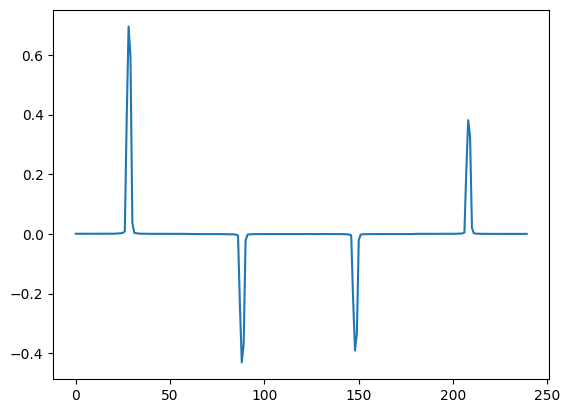

In [2]:
import matplotlib.pyplot as plt

all_y=np.zeros((dataset_size,wl_resolution*4),dtype=np.float32)
for i in range(dataset_size//100):
    fo=np.load("./specturm_collab/data%d.npz"%i)
    temp0=fo["arr_0"]
    temp1=fo["arr_1"]
    if i>0 and i!=2 and i!=36:
        fo=np.load("./specturm_collab/data%d.npz"%(i-1))
        temp0=temp0-fo["arr_0"]
        
    for j in range(100):
        all_y[i*100+j,:wl_resolution] = zoom(temp0[j]/temp1[j]/60000000,wl_resolution/712)
        
        stokes = stokes_from_alphabeta(alpha_array[i*100+j],beta_array[i*100+j])
        all_y[i*100+j,wl_resolution:2*wl_resolution] = stokes[0]*all_y[i*100+j,:wl_resolution]
        all_y[i*100+j,2*wl_resolution:3*wl_resolution] = stokes[1]*all_y[i*100+j,:wl_resolution]
        all_y[i*100+j,3*wl_resolution:] = stokes[2]*all_y[i*100+j,:wl_resolution]
plt.plot(all_y[3601])

In [4]:
from tqdm import tqdm
all_imgs=np.zeros((dataset_size,1,224,224),dtype=np.float32)
fo_p=np.load("./random_parameters.npz")
alpha_array=fo_p["arr_2"]
beta_array=fo_p["arr_3"]

np.random.seed(seed)
shuffled_idx=np.arange(dataset_size)
np.random.shuffle(shuffled_idx)

for i in tqdm(range(dataset_size//100)):
    fo=np.load("./data%d.npz"%i)
    temp0=fo["arr_0"]
    zero_outside(temp0)
    temp0=temp0[:,interesting_region[0,0]:interesting_region[1,0],interesting_region[0,1]:interesting_region[1,1]]
    temp1=fo["arr_1"]
    for j in range(100):
        if i*100+j in shuffled_idx[split_size[0]+split_size[1]:]:
            all_imgs[i*100+j,0] = zoom(temp0[j]*temp1[j],(224/active_y,224/active_x))
all_imgs=all_imgs/np.max(all_imgs)

all_y=np.zeros((dataset_size,wl_resolution*4),dtype=np.float32)
for i in range(dataset_size//100):
    fo=np.load("./specturm_collab/data%d.npz"%i)
    temp0=fo["arr_0"]
    temp1=fo["arr_1"]
    if i>0 and i!=2 and i!=36:
        fo=np.load("./specturm_collab/data%d.npz"%(i-1))
        temp0=temp0-fo["arr_0"]
        
    for j in range(100):
        all_y[i*100+j,:wl_resolution] = zoom(temp0[j]/temp1[j]/60000000,wl_resolution/712)
        
        stokes = stokes_from_alphabeta(alpha_array[i*100+j],beta_array[i*100+j])
        all_y[i*100+j,wl_resolution:2*wl_resolution] = stokes[0]*all_y[i*100+j,:wl_resolution]
        all_y[i*100+j,2*wl_resolution:3*wl_resolution] = stokes[1]*all_y[i*100+j,:wl_resolution]
        all_y[i*100+j,3*wl_resolution:] = stokes[2]*all_y[i*100+j,:wl_resolution]

        
        

all_imgs=all_imgs[shuffled_idx]
all_y=all_y[shuffled_idx]

#x_train=all_imgs[:split_size[0]]
#y_train=all_y[:split_size[0]]
#x_val=all_imgs[split_size[0]:split_size[0]+split_size[1]]
#y_val=all_y[split_size[0]:split_size[0]+split_size[1]]
x_test=all_imgs[split_size[0]+split_size[1]:]
y_test=all_y[split_size[0]+split_size[1]:]

#x_train=torch.from_numpy(x_train).to(device)
#y_train=torch.from_numpy(y_train).to(device)
#x_val=torch.from_numpy(x_val).to(device)
#y_val=torch.from_numpy(y_val).to(device)
x_test=torch.from_numpy(x_test).to(device)
y_test=torch.from_numpy(y_test).to(device)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:10<00:00,  1.41s/it]


[1.1014061e-05 2.4717970e-04 1.4371591e-04] 0.00013687517


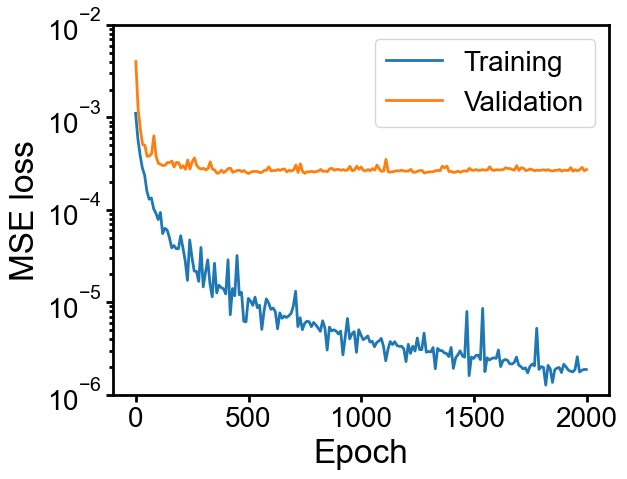

In [61]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
plt.rcParams['font.sans-serif'] = ['Arial']

table=pd.read_csv("./ML_result/ResNet_spec_lr-4_seed715.csv")
best_idx=np.argmin(table["validation_loss"].values)
print(table.iloc[best_idx].values,table["test_loss"].min())

plt.plot(np.arange(table.shape[0])*10-1,table["train_loss"],label="Training",lw=2)
plt.plot(np.arange(table.shape[0])*10,table["validation_loss"],label="Validation",lw=2)


plt.yscale("log")
plt.ylim(0.000001,0.01)
plt.yticks(fontsize=20)
plt.xticks([0,500,1000,1500,2000],fontsize=20)
plt.xlabel("Epoch",fontsize=24)
plt.ylabel("MSE loss",fontsize=24)
plt.legend(fontsize=20)

bwidth=2
plt.tick_params(which="major",width=bwidth,length=5)
plt.tick_params(which="minor",width=bwidth,length=3)
tk=plt.gca()
tk.spines["bottom"].set_linewidth(bwidth)
tk.spines["top"].set_linewidth(bwidth)
tk.spines["left"].set_linewidth(bwidth)
tk.spines["right"].set_linewidth(bwidth)
plt.savefig("./learning_curve.svg",transparent=True,bbox_inches="tight")
plt.show()

In [6]:
model=torch.load("./ML_result/ResNet_spec_lr-4_seed715.pt")
with torch.no_grad():
    y_pred=model(x_test).to("cpu").numpy()

Text(0.5, 0, 'Wavelength (nm)')

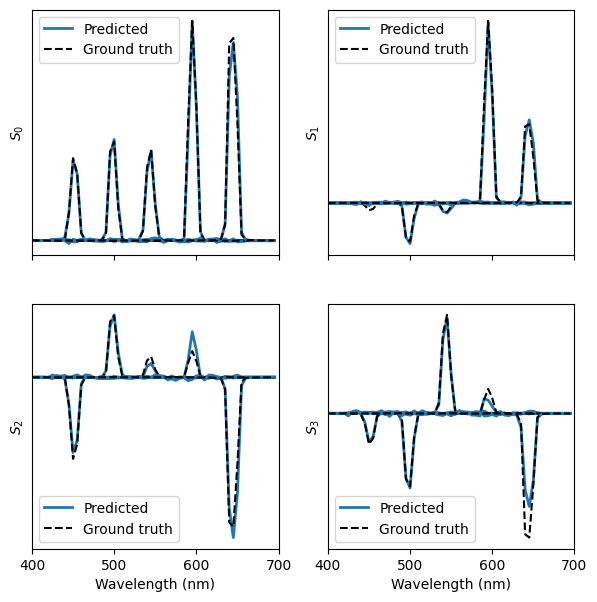

In [54]:
import matplotlib.pyplot as plt
f, axs = plt.subplots(2,2, sharex=True, sharey=False,figsize=(7,7))
wl_array = np.linspace(400,700,60,endpoint=False)
plot_wl=[450,500,548,600,648]
color_list=["tab:blue","tab:cyan","tab:green","tab:orange","tab:red"]

center_wl=fo_p["arr_0"][shuffled_idx[split_size[0]+split_size[1]:]]
plot_idx=[]
for i in range(len(plot_wl)):
    plot_idx.append(np.argmin(np.abs(center_wl-plot_wl[i])))
    
for i in range(len(plot_idx)):
    cur_truth=y_test[plot_idx[i]].to("cpu").numpy()
    for j in range(4):
        axs[j//2,j%2].plot(wl_array,y_pred[plot_idx[i],j*60:(j+1)*60],color="tab:blue",lw=2,label="Predicted")
        axs[j//2,j%2].plot(wl_array,cur_truth[j*60:(j+1)*60],"--",color="black",label="Ground truth")
        
        if i==0:
            axs[j//2,j%2].legend()
            axs[j//2,j%2].set_yticks([])
axs[0,0].set_ylabel(r"$S_0$")
axs[0,1].set_ylabel(r"$S_1$")
axs[1,0].set_ylabel(r"$S_2$")
axs[1,1].set_ylabel(r"$S_3$")
axs[1,1].set_xlim(400,700)
axs[1,1].set_xlabel("Wavelength (nm)")
axs[1,0].set_xlabel("Wavelength (nm)")

In [60]:
y_truth = y_test.to("cpu").numpy()
norm_factor = np.zeros(4)
for j in range(4):
    norm_factor[j] = np.max(y_truth[:,j*60:(j+1)*60])
    y_truth[:,j*60:(j+1)*60] = y_truth[:,j*60:(j+1)*60]/norm_factor[j]
    
result = np.zeros(4)
for i in range(y_truth.shape[0]):
    max_idx = np.argmax(y_truth[i,:60])
    for j in range(4):
        result[j] += np.abs(y_truth[i,j*60:(j+1)*60][max_idx] 
                            - y_pred[i,j*60:(j+1)*60][max_idx]/norm_factor[j])
result = result/y_truth.shape[0]
result

array([0.02634804, 0.04442738, 0.04105405, 0.04496937])